In [1]:
import nbsetup
import numpy as np
import seaborn as sns
import pandas as pd
import itertools
import ensemblepy as ep
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
COUNT = 1000

In [ ]:
from ensemblepy.densityvar import DEFAULT_K, DEFAULT_RANGE, DEFAULT_STEPS, MODES, minmax_variance
import time
STEPS = 1000
K = 10
VRANGE = (-1,2)
DIMENSIONS = (1,2,3,4)
params = (K, VRANGE, STEPS)
vs = {}

for d in DIMENSIONS:
    for m in ('var','entropy'):
        tic = time.time()
        vs[(*params, m, d)] = minmax_variance(*params, mode=m, dimensions=d)
        print(time.time()-tic)

print(vs)

0.5669939517974854
0.530480146408081
9.365864038467407
9.301497220993042


In [4]:
def histplot(dist, ax, normalise):
    sns.histplot(dist, ax=ax, legend=False)
    if normalise is None: dist = (dist - dist.min())/(dist.max()-dist.min())
    y = ep.densities(dist, k=K, var_range=VRANGE, steps=STEPS)
    x = np.linspace(*VRANGE, STEPS)
    sns.lineplot(x=x, y=y, ax=ax.twinx(), legend=False)

def compare(func, normalise=(0,1), dimensions=DIMENSIONS, percent=np.linspace(0,1,11), binrange=(2,3,5,8)):
    data = []
    discrete = []
    dists = []
    for x in percent:
        for d in DIMENSIONS:
            dist = np.array([func(x) for _ in range(d)]).T
            results = {'x': x}
            for m in MODES.keys():
                data.append({
                    'x': x,
                    'y': ep.density_variance(dist, normalise, bounded=False,
                                             k=K, var_range=VRANGE, steps=STEPS, mode=m, vs=vs),
                    'mode': m,
                    'd': d,
                })
            for k in binrange:
                if normalise is not None:
                    bins = np.linspace(normalise[0],normalise[1], k+1)
                else:
                    bins = np.linspace(dist.min(),dist.max(), k+1)
                bins = np.array([bins for _ in range(d)])
                pmf = np.histogramdd(dist, bins=bins)[0].flatten()
                ent = sp.stats.entropy(pmf)/np.log(len(pmf))
                
                discrete.append({
                        'x': x,
                        'y': ent,
                        'bins': k,
                        'mode': 'discrete',
                        'd': d,
                    })
            if d == 1:
                dists.append(dist[0])
    data, discrete = pd.DataFrame(data), pd.DataFrame(discrete)
    
    fig, axes = plt.subplots(2,4,figsize=(20,10))
    histplot(dists[len(dists)//10], axes[0][0], normalise)
    histplot(dists[int(len(dists)*9/10)], axes[0][-1], normalise)
    
    for i, m in enumerate(('var', 'entropy')):
        sns.lineplot(data=data[data['mode']==m], x='x', y='y', hue='d', ax=axes[0][i+1]).set(title=m, ylim=(0,1))
    
    for i, b in enumerate(binrange):
        sns.lineplot(data=discrete[discrete['bins']==b], x='x', y='y', hue='d', ax=axes[1][i])

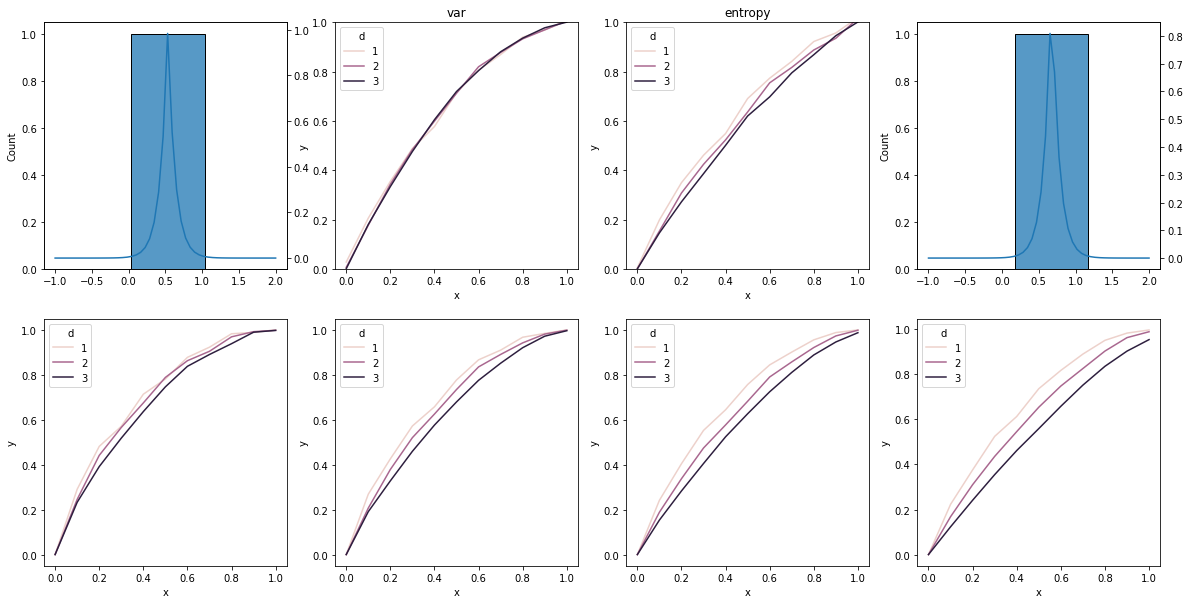

In [5]:
compare(lambda p: np.concatenate([np.random.uniform(0, 1, int(COUNT*p)), np.ones(int(COUNT*(1-p)))*0.5]))

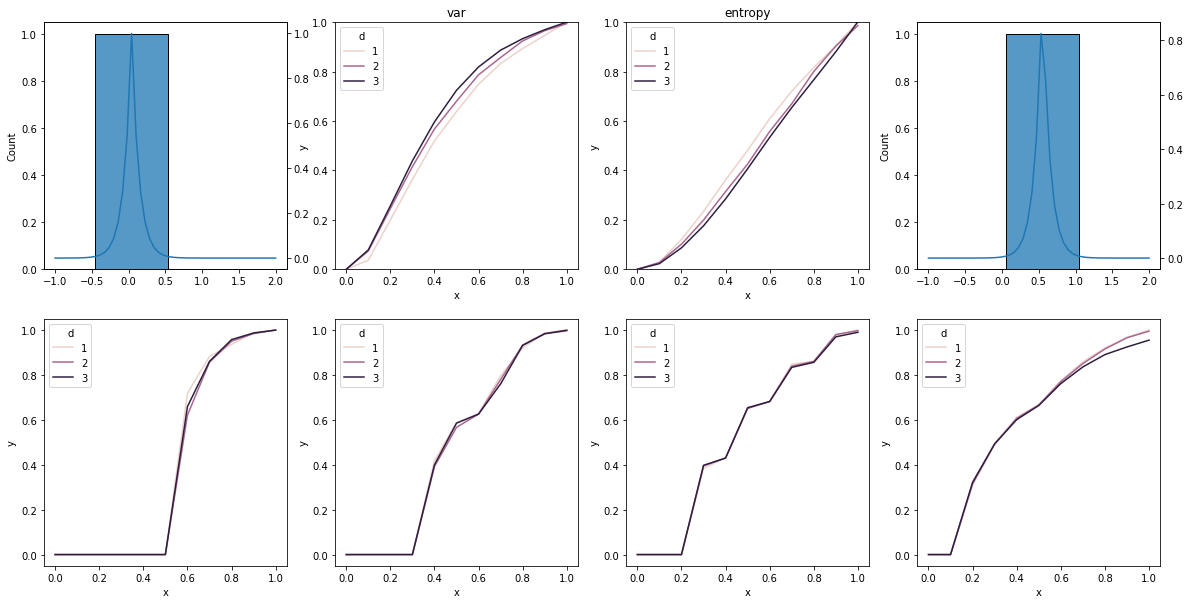

In [6]:
compare(lambda p: np.random.uniform(0, p, COUNT))

<ipython-input-4-75a594d65e41>:3: RuntimeWarning: invalid value encountered in true_divide
  if normalise is None: dist = (dist - dist.min())/(dist.max()-dist.min())
<ipython-input-4-75a594d65e41>:3: RuntimeWarning: invalid value encountered in true_divide
  if normalise is None: dist = (dist - dist.min())/(dist.max()-dist.min())


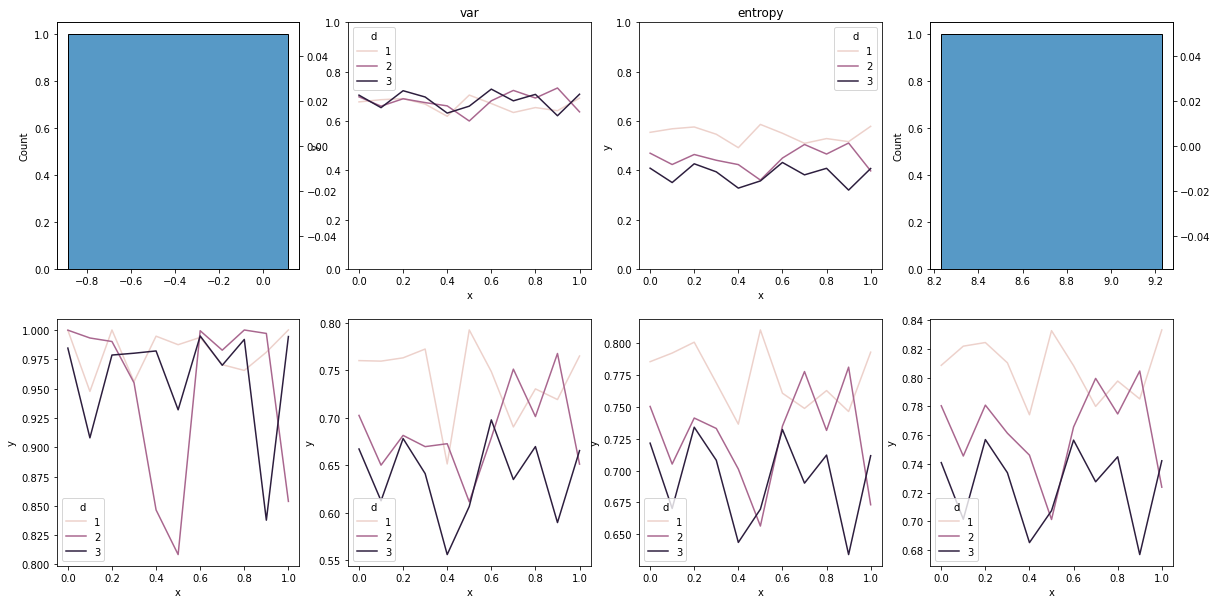

In [7]:
compare(lambda p: np.random.normal(0, 10**p, COUNT) , None)

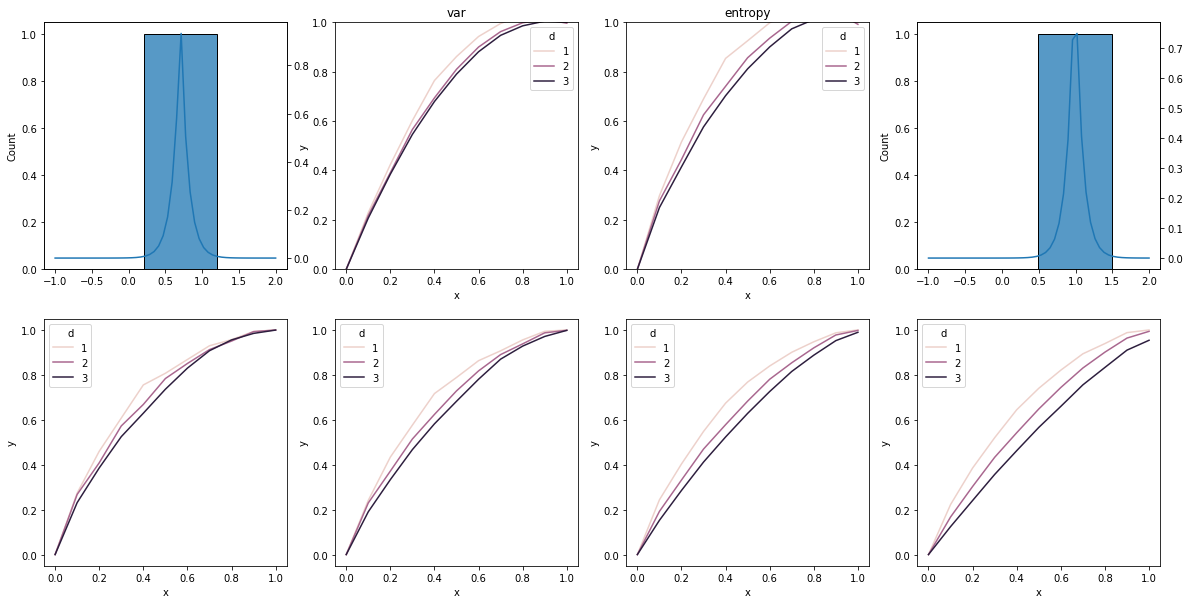

In [8]:
compare(lambda p: np.concatenate([np.random.uniform(0, 1, int(COUNT*p)), np.ones(int(COUNT*(1-p)))]))

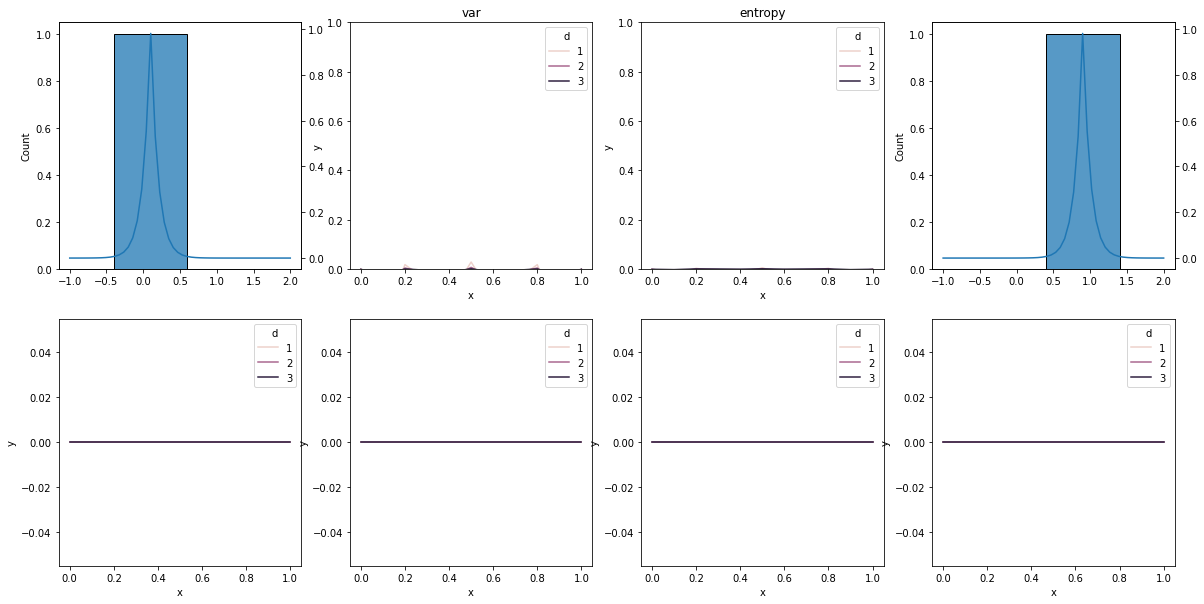

In [9]:
compare(lambda p: np.ones(COUNT)*p)

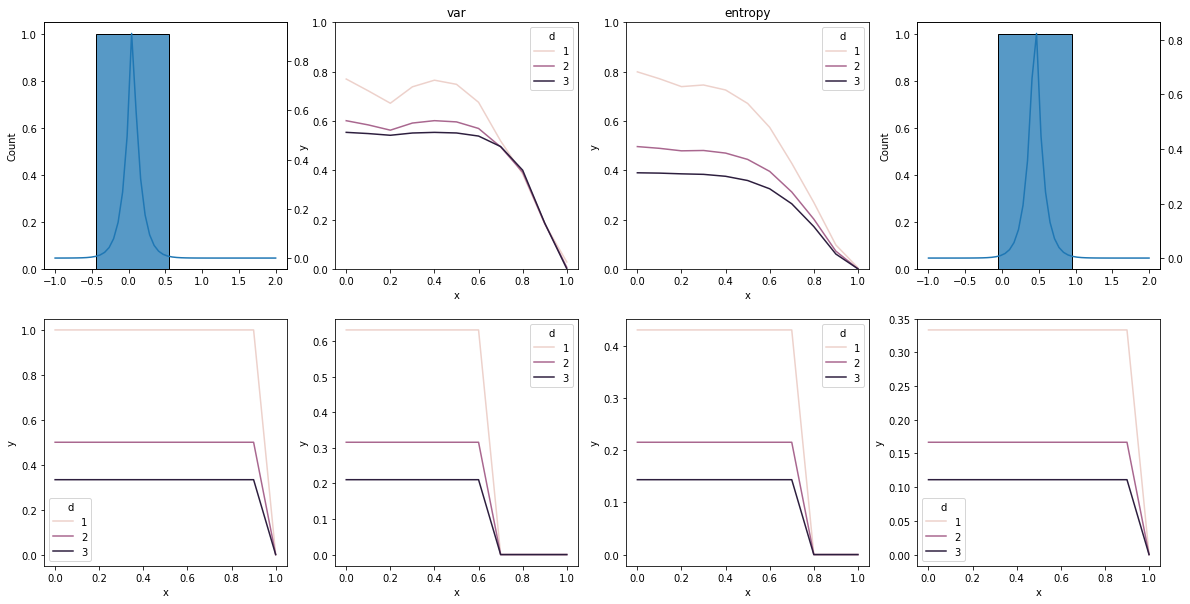

In [10]:
compare(lambda p: np.concatenate([np.ones(COUNT)*(p/2),np.ones(COUNT)*(1-p/2)]))